In [11]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Autoreload magic command
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
num_samples = 500
p1_range = [0, 1]
p2_range = [0, 1]


def f(p1, p2):
    return (p1 - 0.1) ** 2 + 4 * (p2 - 0.1) ** 2 - 0.64


def FI(df: pd.DataFrame) -> float:
    return len(df[df["label"] == 1]) / len(df)


# Generate a dataset
df = pd.DataFrame(columns=["p1", "p2", "f", "label"])
df["p1"] = np.random.uniform(p1_range[0], p1_range[1], num_samples)
df["p2"] = np.random.uniform(p2_range[0], p2_range[1], num_samples)
df["f"] = f(df["p1"], df["p2"])
df["label"] = (df["f"] < 0).astype(int)
df.drop("f", axis=1, inplace=True)

print(f"FI = {FI(df)}")

df.head()

FI = 0.38


,p1,p2,label
0,0.774849,0.555876,0
1,0.148844,0.461834,1
2,0.712681,0.674365,0
3,0.668242,0.449361,0
4,0.763212,0.687895,0


In [13]:
def train_cart(df: pd.DataFrame, label: str) -> DecisionTreeClassifier:
    cart = DecisionTreeClassifier()
    X = df.drop(columns=[label])
    y = df[label]
    
    # Define parameter grid
    param_grid = {
        'max_depth': np.arange(2, 12, 1),
        'min_samples_split': np.arange(0, int(len(df) * .8), 1),
        'min_samples_leaf': np.arange(1, int(len(df) * .8), 1),
    }
    
    search = RandomizedSearchCV(cart, param_grid, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)
    search.fit(X, y)
    cart = search.best_estimator_
    print(f"Best parameters: {search.best_params_}")
    print(f"Best score: {search.best_score_}")
    return cart

In [14]:
cart = train_cart(df, "label")

Best parameters: {'min_samples_split': 148, 'min_samples_leaf': 14, 'max_depth': 6}
Best score: 0.942


c:\Users\mexis\anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mexis\anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mexis\anaconda3\envs\main\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\mexis\anaconda3\envs\main\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\U

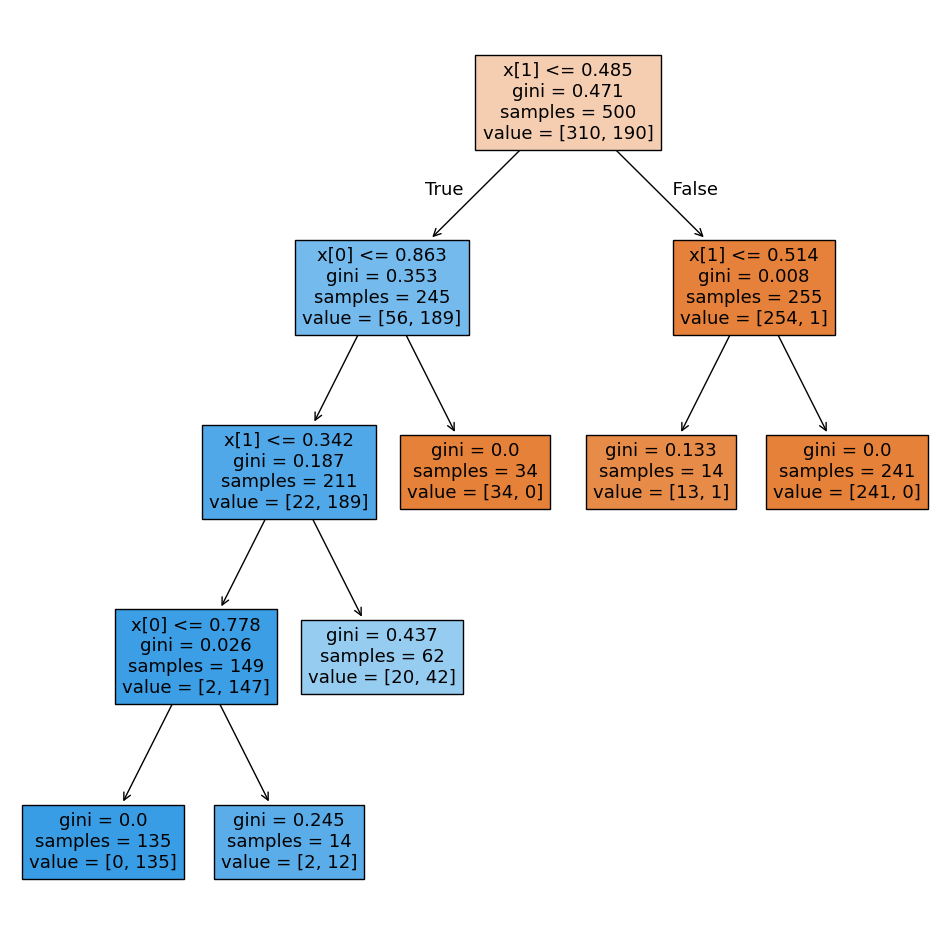

In [15]:
plt.figure(figsize=(12, 12))
plot_tree(cart, filled=True)
plt.show()

In [19]:
from ml2rules.machinelearning import MyClass

my_class = MyClass(df, 'label', cart)
my_class.get_rules()
my_class.rules

['if (p2 > 0.485) and (p2 > 0.514) then class: 0 (proba: 100.0%) | based on 241 samples',
 'if (p2 <= 0.485) and (p1 <= 0.863) and (p2 <= 0.342) and (p1 <= 0.778) then class: 1 (proba: 100.0%) | based on 135 samples',
 'if (p2 <= 0.485) and (p1 <= 0.863) and (p2 > 0.342) then class: 1 (proba: 67.74%) | based on 62 samples',
 'if (p2 <= 0.485) and (p1 > 0.863) then class: 0 (proba: 100.0%) | based on 34 samples',
 'if (p2 > 0.485) and (p2 <= 0.514) then class: 0 (proba: 92.86%) | based on 14 samples',
 'if (p2 <= 0.485) and (p1 <= 0.863) and (p2 <= 0.342) and (p1 > 0.778) then class: 1 (proba: 85.71%) | based on 14 samples']

In [20]:
rdf = my_class.get_rules_df()
rdf

,feature,ineq,value,rule,class
0,p2,<=,0.4854,0,1.0
1,p1,<=,0.8626,0,1.0
2,p2,<=,0.3417,0,1.0
3,p1,<=,0.7780,0,1.0
4,p1,>,0.7780,1,1.0
5,p2,>,0.3417,2,1.0
6,p1,>,0.8626,3,0.0
7,p2,>,0.4854,4,0.0
8,p2,<=,0.5140,4,0.0
9,p2,>,0.5140,5,0.0
